>>> TESTING VOLATILITY EXPANSION HYPOTHESIS FOR NVDA <<<

--- RESULTS (2020-01-01 to 2025-05-05) ---
Buy & Hold Return:   1817.23%
Trend Only (ADX>25): 0.00%
Chop Only (ADX<25):  1817.23%


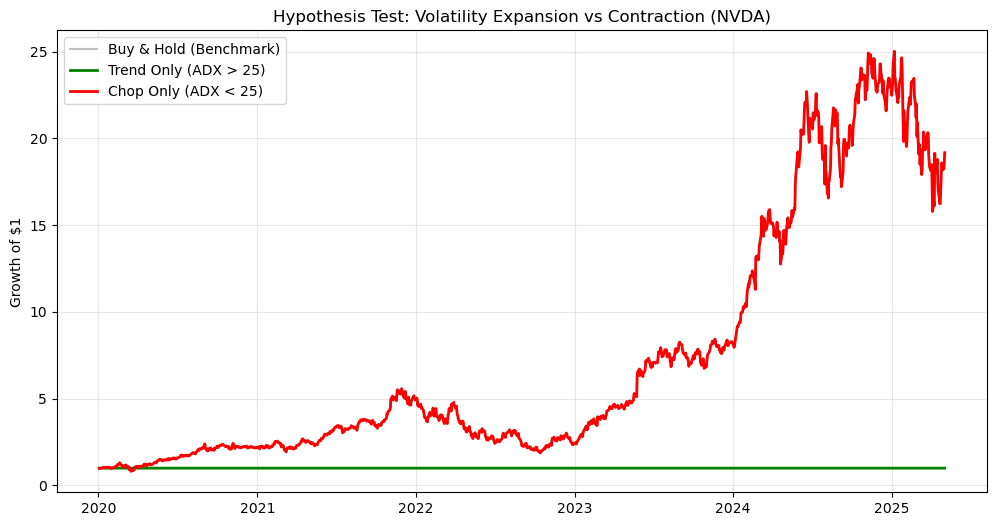


>>> VERDICT: HYPOTHESIS REJECTED. Chop Regime contributes significantly. <<<
Recommendation: Refine Accumulation Logic (Mean Reversion).


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
TICKER = "NVDA"
START_DATE = "2020-01-01"
END_DATE = "2025-05-05"
ADX_THRESHOLD = 25
ADX_WINDOW = 14

def calculate_adx(df, window=14):
    """
    Calculates the Average Directional Index (ADX).
    """
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # 1. True Range
    tr = np.maximum(high - low, 
           np.maximum(abs(high - close.shift(1)), 
                      abs(low - close.shift(1))))
    
    # 2. Directional Movement
    dm_plus = np.where((high - high.shift(1)) > (low.shift(1) - low), 
                       np.maximum(high - high.shift(1), 0), 0)
    dm_minus = np.where((low.shift(1) - low) > (high - high.shift(1)), 
                        np.maximum(low.shift(1) - low, 0), 0)
    
    # 3. Smoothed TR and DM (Wilder's Smoothing)
    # Using simple rolling mean for approximation in this test script
    # For production, use exponential moving average or Wilder's specific smoothing
    tr_s = tr.rolling(window).sum()
    dm_plus_s = pd.Series(dm_plus).rolling(window).sum()
    dm_minus_s = pd.Series(dm_minus).rolling(window).sum()
    
    # 4. DI+ and DI-
    di_plus = 100 * (dm_plus_s / tr_s)
    di_minus = 100 * (dm_minus_s / tr_s)
    
    # 5. DX and ADX
    dx = 100 * abs(di_plus - di_minus) / (di_plus + di_minus)
    adx = dx.rolling(window).mean()
    
    return adx.fillna(0)

def run_hypothesis_test():
    print(f">>> TESTING VOLATILITY EXPANSION HYPOTHESIS FOR {TICKER} <<<")
    
    # 1. Data Fetch
    data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
    
    # Handle MultiIndex columns (Fix for yfinance > 0.2)
    if isinstance(data.columns, pd.MultiIndex):
        try:
            # If ticker is in level 1, drop it to get simple OHLC columns
            if TICKER in data.columns.get_level_values(1):
                data = data.xs(TICKER, axis=1, level=1)
            # Fallback: Just drop the second level if it exists
            elif data.columns.nlevels > 1:
                data.columns = data.columns.droplevel(1)
        except Exception:
            pass

    # Ensure 'Close' column exists
    if 'Close' not in data.columns and 'Adj Close' in data.columns:
        data['Close'] = data['Adj Close']
        
    # Ensure High/Low exist for ADX
    if 'High' not in data.columns or 'Low' not in data.columns:
        print("Warning: High/Low data missing. ADX calculation may fail.")

    # 2. Feature Engineering
    data['returns'] = data['Close'].pct_change()
    data['adx'] = calculate_adx(data, window=ADX_WINDOW)
    
    # 3. Segmentation Logic
    # Strategy A: "Chop" (Accumulation) - Hold ONLY when ADX < 25
    # Strategy B: "Trend" (Expansion) - Hold ONLY when ADX > 25
    
    data['signal_chop'] = np.where(data['adx'] < ADX_THRESHOLD, 1.0, 0.0)
    data['signal_trend'] = np.where(data['adx'] > ADX_THRESHOLD, 1.0, 0.0)
    
    # Lag signal by 1 day to avoid look-ahead bias (trade on yesterday's ADX)
    data['signal_chop'] = data['signal_chop'].shift(1)
    data['signal_trend'] = data['signal_trend'].shift(1)
    
    # 4. PnL Calculation
    data['pnl_chop'] = data['returns'] * data['signal_chop']
    data['pnl_trend'] = data['returns'] * data['signal_trend']
    
    # Cumulative Returns
    data['cum_chop'] = (1 + data['pnl_chop']).cumprod()
    data['cum_trend'] = (1 + data['pnl_trend']).cumprod()
    data['cum_hold'] = (1 + data['returns']).cumprod() # Benchmark
    
    # 5. Results
    final_chop = data['cum_chop'].iloc[-1] - 1
    final_trend = data['cum_trend'].iloc[-1] - 1
    final_hold = data['cum_hold'].iloc[-1] - 1
    
    print(f"\n--- RESULTS ({START_DATE} to {END_DATE}) ---")
    print(f"Buy & Hold Return:   {final_hold:.2%}")
    print(f"Trend Only (ADX>25): {final_trend:.2%}")
    print(f"Chop Only (ADX<25):  {final_chop:.2%}")
    
    # 6. Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['cum_hold'], label='Buy & Hold (Benchmark)', color='gray', alpha=0.5)
    plt.plot(data.index, data['cum_trend'], label='Trend Only (ADX > 25)', color='green', linewidth=2)
    plt.plot(data.index, data['cum_chop'], label='Chop Only (ADX < 25)', color='red', linewidth=2)
    
    plt.title(f"Hypothesis Test: Volatility Expansion vs Contraction ({TICKER})")
    plt.ylabel("Growth of $1")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # 7. Verdict
    if final_chop < 0:
        print("\n>>> VERDICT: HYPOTHESIS CONFIRMED. Chop Regime is Negative EV. <<<")
        print("Recommendation: DELETE Accumulation Agent for this asset.")
    elif final_chop < final_hold * 0.1:
        print("\n>>> VERDICT: HYPOTHESIS SUPPORTED. Chop Regime is Dead Money. <<<")
        print("Recommendation: Replace Accumulation with Cash/Yield.")
    else:
        print("\n>>> VERDICT: HYPOTHESIS REJECTED. Chop Regime contributes significantly. <<<")
        print("Recommendation: Refine Accumulation Logic (Mean Reversion).")

if __name__ == "__main__":
    run_hypothesis_test()